# Problem 2:
predicting turbine energy yield (TEY) using ambient variables as features.

## 1. Import necessary libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Layer, Lambda 
from scikeras.wrappers import KerasRegressor

In [2]:
%matplotlib notebook

## 2. Load data

In [3]:
gasturb_df = pd.read_csv('gas_turbines.csv')

In [4]:
gasturb_df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311


## 3. EDA

In [5]:
gasturb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15039 entries, 0 to 15038
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      15039 non-null  float64
 1   AP      15039 non-null  float64
 2   AH      15039 non-null  float64
 3   AFDP    15039 non-null  float64
 4   GTEP    15039 non-null  float64
 5   TIT     15039 non-null  float64
 6   TAT     15039 non-null  float64
 7   TEY     15039 non-null  float64
 8   CDP     15039 non-null  float64
 9   CO      15039 non-null  float64
 10  NOX     15039 non-null  float64
dtypes: float64(11)
memory usage: 1.3 MB


In [6]:
gasturb_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AT,15039.0,17.764381,7.574323,0.522300,11.408000,18.1860,23.8625,34.9290
AP,15039.0,1013.199240,6.410760,985.850000,1008.900000,1012.8000,1016.9000,1034.2000
AH,15039.0,79.124174,13.793439,30.344000,69.750000,82.2660,90.0435,100.2000
AFDP,15039.0,4.200294,0.760197,2.087400,3.723900,4.1862,4.5509,7.6106
GTEP,15039.0,25.419061,4.173916,17.878000,23.294000,25.0820,27.1840,37.4020
TIT,15039.0,1083.798770,16.527806,1000.800000,1079.600000,1088.7000,1096.0000,1100.8000
TAT,15039.0,545.396183,7.866803,512.450000,542.170000,549.8900,550.0600,550.6100
TEY,15039.0,134.188464,15.829717,100.170000,127.985000,133.7800,140.8950,174.6100
CDP,15039.0,12.102353,1.103196,9.904400,11.622000,12.0250,12.5780,15.0810
CO,15039.0,1.972499,2.222206,0.000388,0.858055,1.3902,2.1604,44.1030


### 3.1 Separating data into features and target

In [7]:
# List of features and target.
cols = gasturb_df.columns
target_col = 'TEY'
features = [feature for feature in cols if feature != target_col]

In [8]:
# X-y split.
X = gasturb_df.loc[:, features]
y = gasturb_df.loc[:, target_col]

### 3.2 Visualizations:

#### a) Distribution of features

<IPython.core.display.Javascript object>


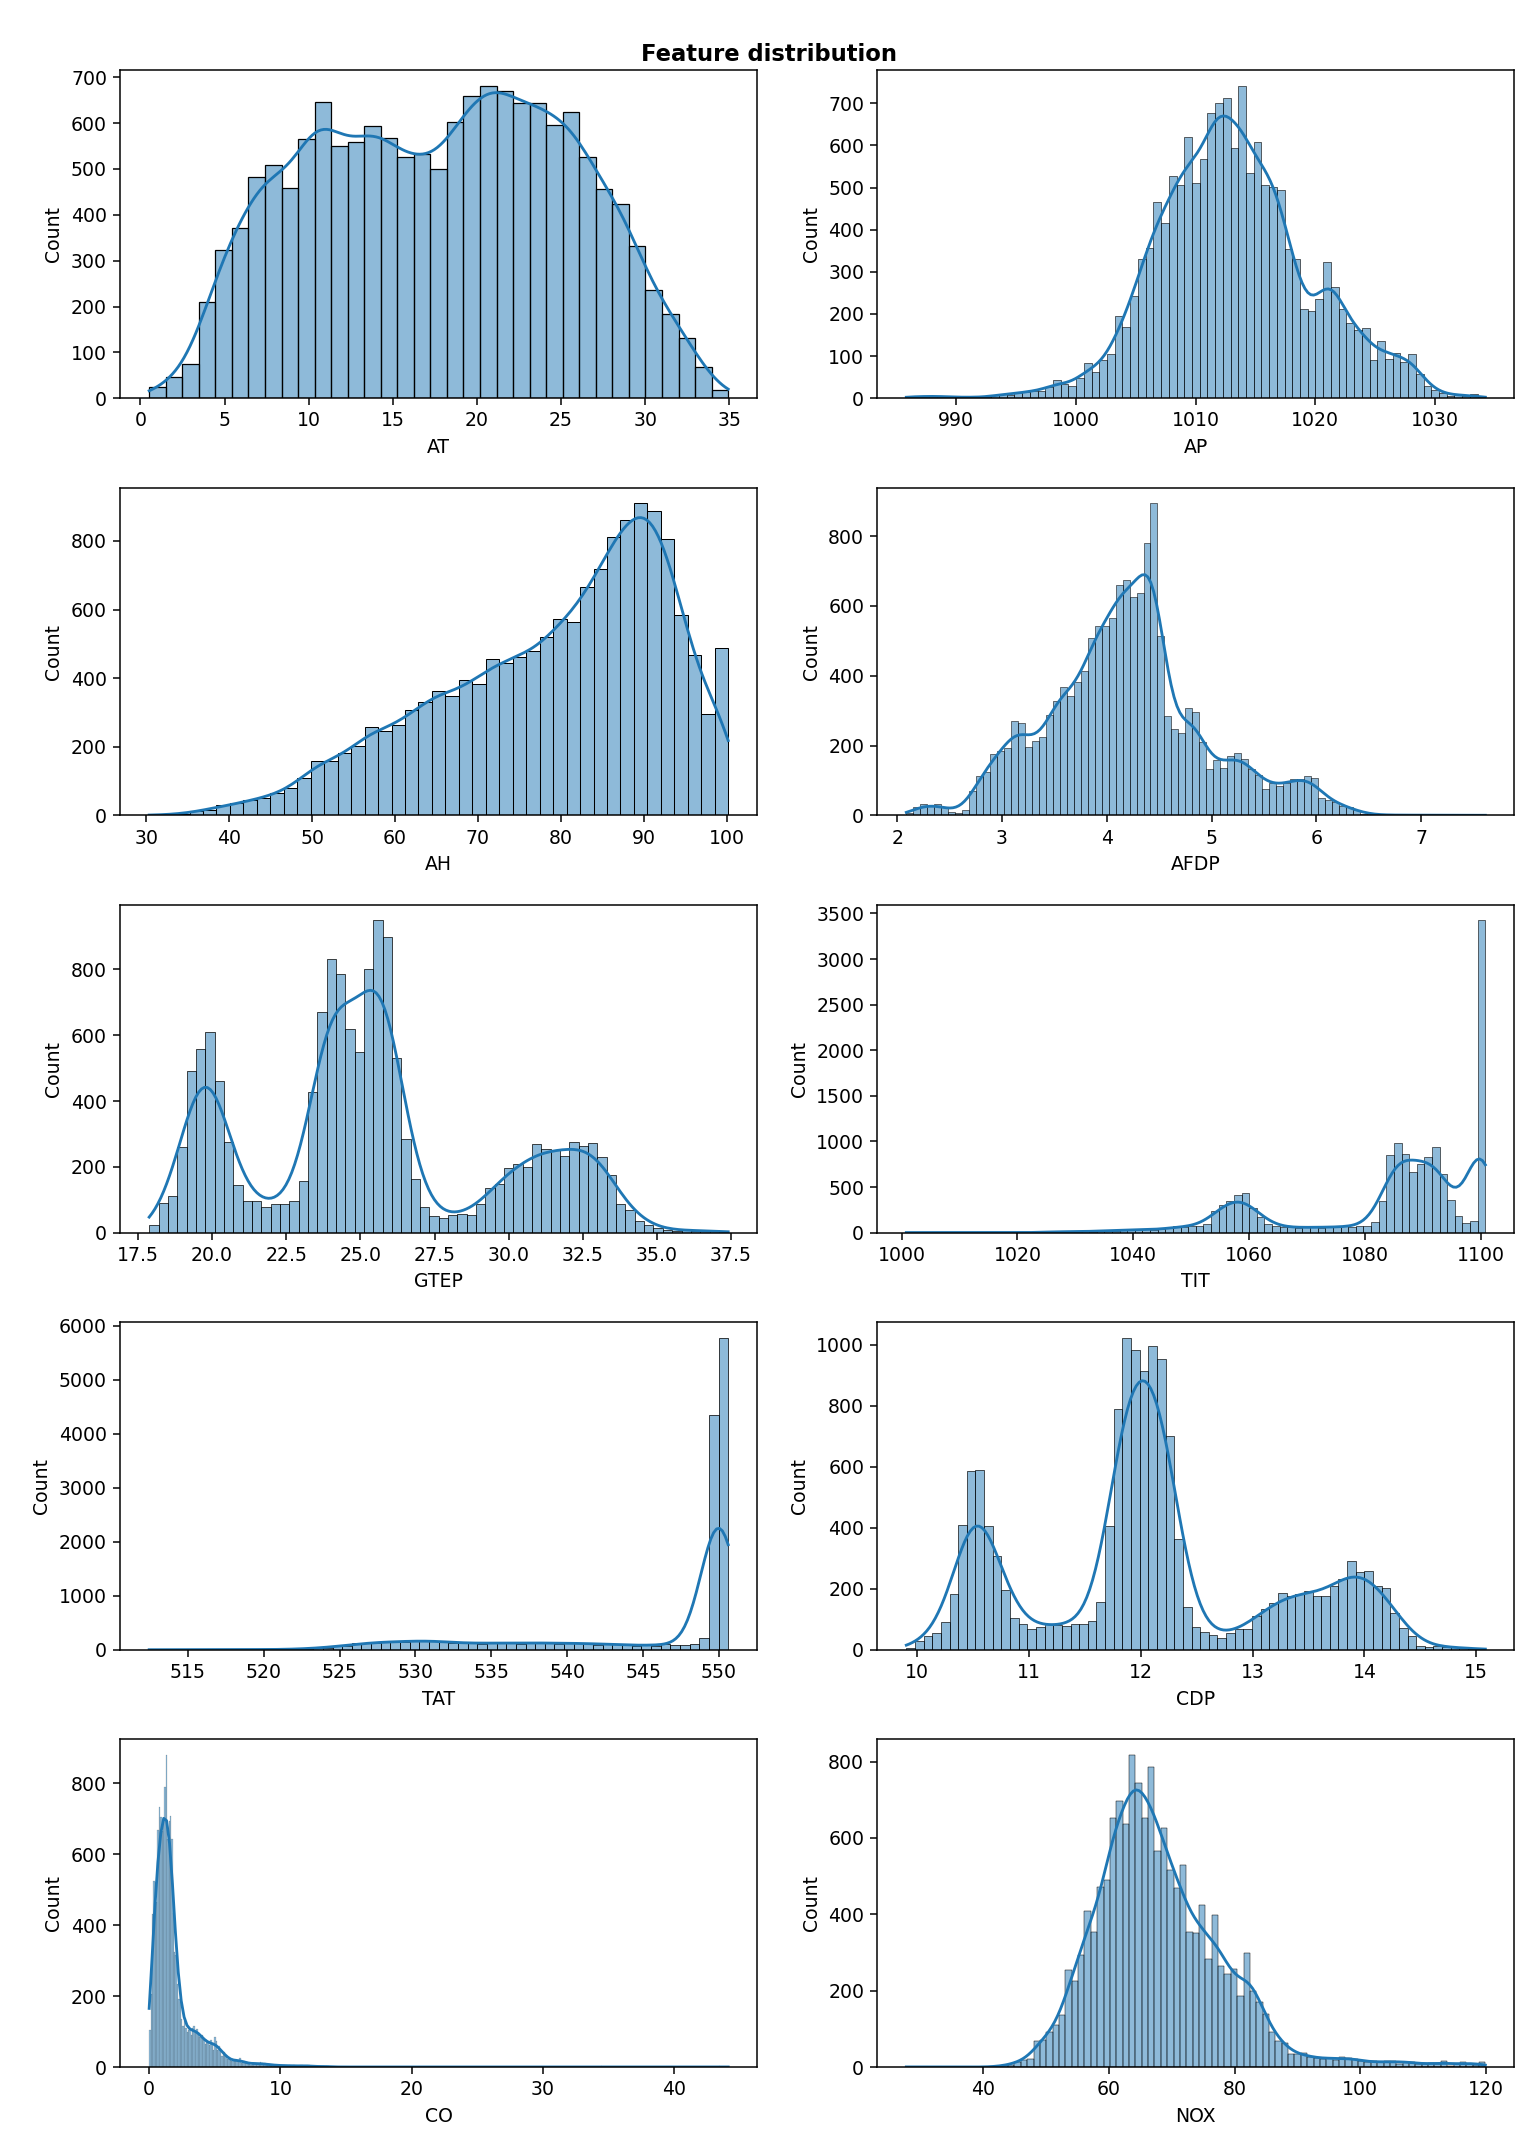

In [9]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10,14))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    sns.histplot(data=X, x=X[features[idx]], ax=ax, kde=True)
    
fig.suptitle('Feature distribution', ha='center', fontweight='bold')
fig.tight_layout()
plt.show()

#### b) Heatmap to check for correlations

<IPython.core.display.Javascript object>


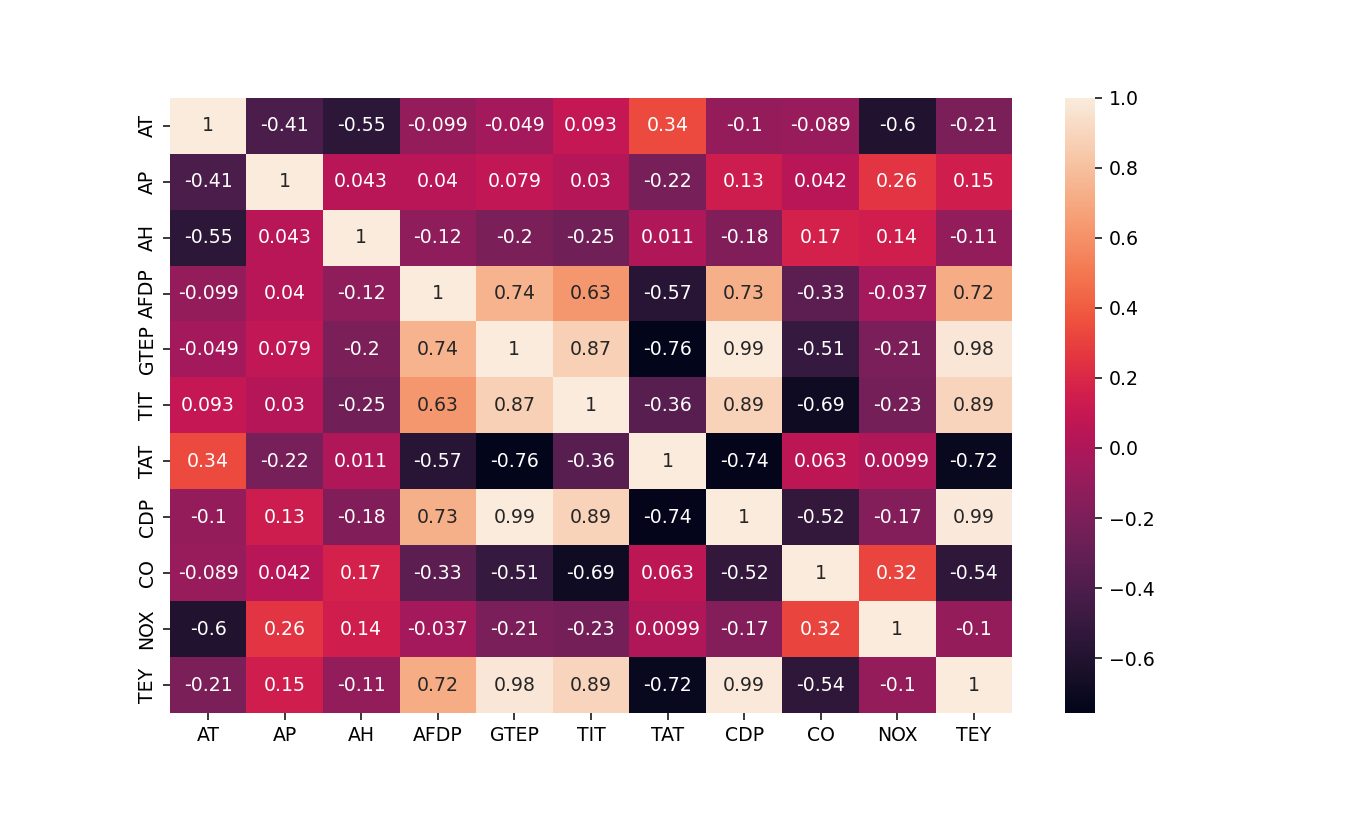

<AxesSubplot:>

In [10]:
df_heatmap = pd.concat([X,y], axis=1)
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(df_heatmap.corr(), ax=ax, annot=True)

#### C) Target distribution

<IPython.core.display.Javascript object>


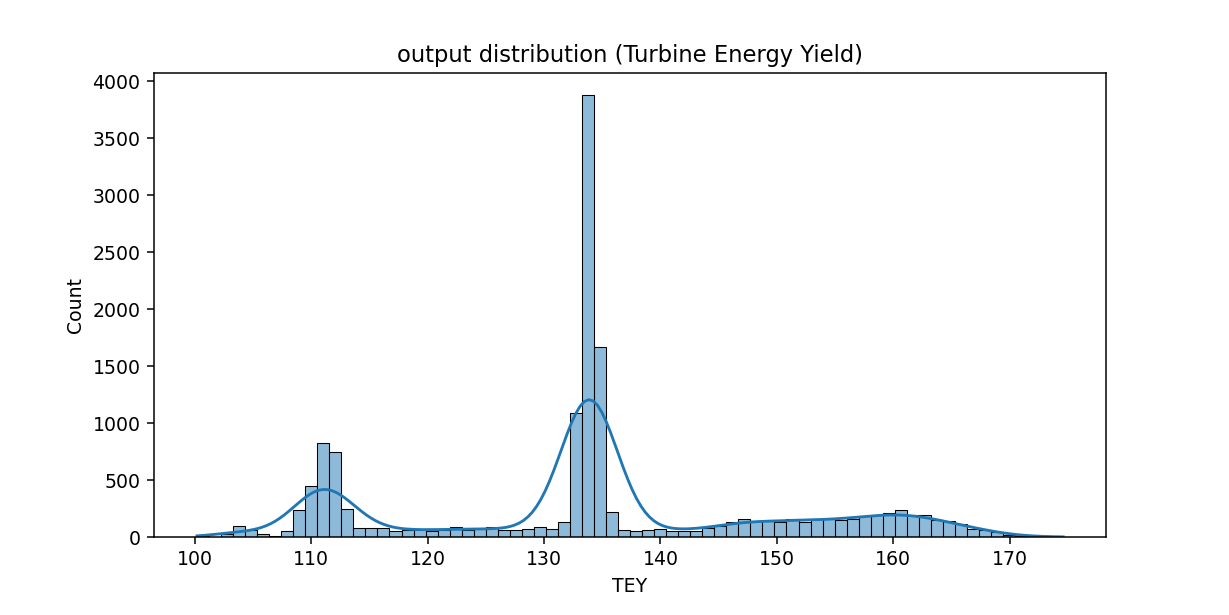

In [11]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=y, x=y, ax=ax, kde=True)
plt.title('output distribution (Turbine Energy Yield)')
plt.show()

### 3.3 Observations:
- 15039 records, 10 features and one target ('TEY')
- No null values.
- All columns with correct datatypes.
- To predict Turbine Energy Yeild.
- All features are numeric (continuous).
- Except NOX and AP, all other features have a somewhat skewed or multimodal distributions.
- The target distribution is bimodal.
- There are some strong correlations between the features.
- The features: CDP, GTEP, TTT, AFDP have a very strong positive correlation with target (TEY).
- The features: TAT, CO have strong negative correlation with the target.
- The features AP has a weak positive correlation with the target.
- The feature AT, NOX has a weak correlation with the target.
- Since there is a strong correlation between majority of the features and target, the problem may yield to regression methods.

## 4. Model building
Ref: https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

### 4.1 Baseline model

In [12]:
# Define baseline model:
def baseline_model():
    # Create model
    model = Sequential()
    model.add(Dense(15, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [13]:
# Evaluate model
estimator = KerasRegressor(model=baseline_model, epochs=10, batch_size=5, verbose=1)
kfold = KFold(n_splits=10)
results = cross_val_score(estimator, X, y, cv=kfold, scoring='neg_mean_squared_error')
print("Baseline: {:.2f} ({:.2f}) MSE".format(results.mean(), results.std()))

Epoch 1/10
2707/2707 [==============================] - 8s 3ms/step - loss: 271.1657
Epoch 2/10
2707/2707 [==============================] - 6s 2ms/step - loss: 53.4190
Epoch 3/10
2707/2707 [==============================] - 7s 3ms/step - loss: 11.4611
Epoch 4/10
2707/2707 [==============================] - 9s 3ms/step - loss: 6.9547
Epoch 5/10
2707/2707 [==============================] - 8s 3ms/step - loss: 4.9347
Epoch 6/10
2707/2707 [==============================] - 7s 3ms/step - loss: 3.6914
Epoch 7/10
2707/2707 [==============================] - 7s 3ms/step - loss: 3.1703
Epoch 8/10
2707/2707 [==============================] - 7s 3ms/step - loss: 2.7599
Epoch 9/10
2707/2707 [==============================] - 7s 3ms/step - loss: 2.4045
Epoch 10/10
301/301 [==============================] - 1s 2ms/step
Epoch 1/10
2707/2707 [==============================] - 6s 2ms/step - loss: 432.8882
Epoch 2/10
2707/2707 [==============================] - 5s 2ms/step - loss: 78.2379
Epoch 3/10
27

2708/2708 [==============================] - 7s 3ms/step - loss: 12.2886
Epoch 4/10
2708/2708 [==============================] - 8s 3ms/step - loss: 7.5878
Epoch 5/10
2708/2708 [==============================] - 7s 3ms/step - loss: 5.5531
Epoch 6/10
2708/2708 [==============================] - 7s 3ms/step - loss: 4.2186
Epoch 7/10
2708/2708 [==============================] - 7s 3ms/step - loss: 3.5254
Epoch 8/10
2708/2708 [==============================] - 7s 3ms/step - loss: 2.8906
Epoch 9/10
2708/2708 [==============================] - 7s 3ms/step - loss: 2.5889
Epoch 10/10
301/301 [==============================] - 1s 2ms/step
Baseline: -2.17 (0.87) MSE


### 4.2 Baseline model, standardization

In [14]:
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=10, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_mean_squared_error')
print("Baseline, Standardized: {:.2f} ({:.2f}) MSE".format(results.mean(), results.std()))

Baseline, Standardized: -1.05 (0.66) MSE


### 4.3 Experimenting with a denser model - Model 1

In [15]:
# Define a larger model than baseline with additional neurons:
def larger_model():
    # Create model
    model = Sequential()
    model.add(Dense(15, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [16]:
# Evaluate the model
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=larger_model, epochs=10, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_mean_squared_error')
print('Larger: {:.2f}({:.2f} MSE'.format(results.mean(), results.std()))


Larger: -0.98(0.45 MSE


### 4.4 Experimenting with a wider network - Model 2

In [17]:
# Define wider model:
def wider_model():
    # create_model
    model = Sequential()
    model.add(Dense(30, input_dim=10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [18]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=wider_model, epochs=10, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_mean_squared_error')
print('wider: {:.2f} ({:.2f}) MSE'.format(results.mean(), results.std()))

wider: -0.90 (0.34) MSE


### 4.5 Observations:
- The 'larger_model' has slightly lower MSE than the baseline_model with standardization.
- The 'wider_model' has slightly higher MSE than the 'larger_model', but a slightly lesser spread (0.33). Thus, we can choose the 'wider_model' (section 4.4, Model 2) as the final model for our analysis because of its lower spread.

### 4.6 Final model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12031, 10), (3008, 10), (12031,), (3008,))

In [21]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=wider_model, epochs=10, batch_size=5, verbose=0)))
final_model = Pipeline(estimators)

In [22]:
final_model.fit(X_train, y_train)

Pipeline(steps=[('standardize', StandardScaler()),
                ('mlp',
                 KerasRegressor(batch_size=5, epochs=10, model=<function wider_model at 0x000001F58B3AD288>, verbose=0))])

#### 4.6.1 FInal model - evaluation

In [23]:
y_pred = pd.Series(final_model.predict(X_test), index=y_test.index)

In [24]:
y_pred

13312    134.904068
12627    112.281769
6393     134.737473
4990     134.046936
12462    110.636505
            ...    
11478    119.839760
12302    134.223297
13093    146.278259
2699     149.669037
12506    111.686111
Length: 3008, dtype: float32

In [25]:
mse =mean_squared_error(y_test, y_pred)

In [26]:
print("The mean square error for Turbine Energy Yield predictions from the neural network model is:{:.3f} ".format(mse))

The mean square error for Turbine Energy Yield predictions from the neural network model is:0.595 


<IPython.core.display.Javascript object>


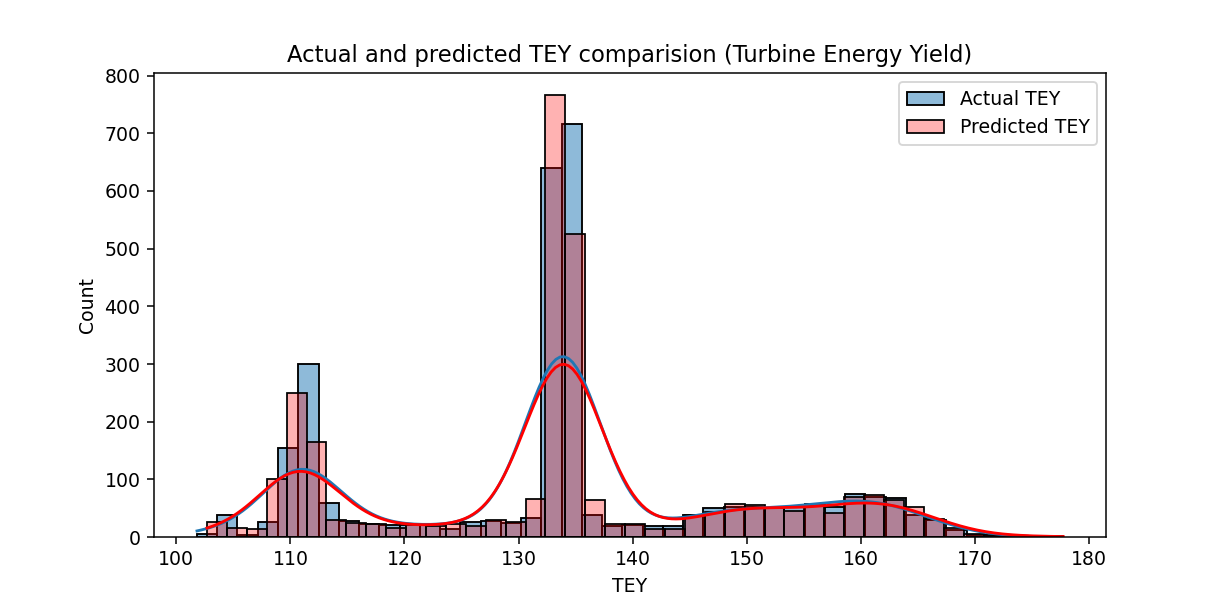

In [27]:
fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(data=y_test, x=y_test, ax=ax, kde=True, label='Actual TEY')
sns.histplot(data=y_pred, x=y_pred, ax=ax, kde=True, color='r', alpha=0.3, label='Predicted TEY')
plt.title('Actual and predicted TEY comparision (Turbine Energy Yield)')
plt.legend()
plt.show()

#### 4.6.2 Observations:
We can see from the above plot that the distribution of the predicted TEY follows closely, the actual TEY.

## 5. Conclusions:
Different neural networks were constructued to predict the Turbine Energy Yield of gas turbines. It was found that **"Model 2"** (having a **shallow hidden layer**) was **predicting the TEY with a smaller MSE than** the **baseline** with minimum spread. This model was finalized and used to predict TEY for the test set. The **predicted TEY was found to agree with actual**, with a very small maean squared error.